<a href="https://colab.research.google.com/github/sipocz/Colab/blob/main/10_Task_handout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feladat: Regularizációs eljárások összehasonlítása a notMNIST adatszetten


A notMNIST egy drop-in MNIST replacement, de nehezebb feladat -- számjegyek helyett A-tól J-ig betűket ábrázolnak a képek.

Pl. az "A" osztály néhány eleme:
<img src="http://yaroslavvb.com/upload/notMNIST/nmn.png">

# Adat le- és betöltés

In [ ]:
! wget https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/train-labels-idx1-ubyte.gz
! wget https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/train-images-idx3-ubyte.gz

--2021-02-11 20:04:48--  https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/train-labels-idx1-ubyte.gz
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29455 (29K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===================>]  28.76K  --.-KB/s    in 0s      

2021-02-11 20:04:48 (75.9 MB/s) - ‘train-labels-idx1-ubyte.gz’ saved [29455/29455]

--2021-02-11 20:04:49--  https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/train-images-idx3-ubyte.gz
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19997892 (19M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-i

In [ ]:
import numpy as np
import os
import gzip

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`.
    """
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
images, labels = load_mnist('.')
                             
train_images = images[:5000]
train_labels = labels[:5000]
valid_images = images[5000:5500]
valid_labels = labels[5000:5500]
test_images = images[5500:6000]
test_labels = labels[5500:6000]

print(train_images.shape, valid_images.shape, test_images.shape)
print(train_labels.shape, valid_labels.shape, test_labels.shape)

(5000, 784) (500, 784) (500, 784)
(5000,) (500,) (500,)


Vessünk egy pillantást az adatainkra:

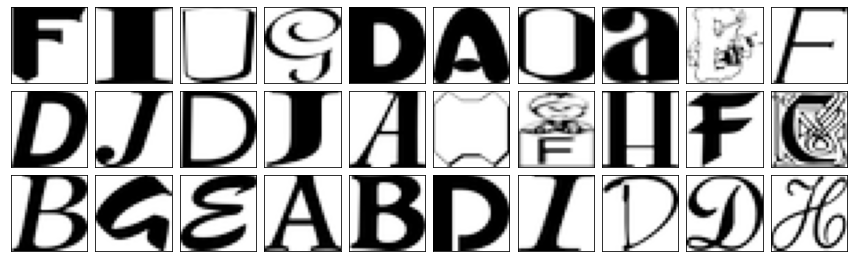

In [ ]:
from matplotlib import pyplot as plt
from math import ceil

def show_images(images):
    """Show images in a grid
    """
    n_rows = ceil(len(images) / 10)
    fig, ax = plt.subplots(n_rows, 10, figsize=(15, 1.5 * n_rows),
                           subplot_kw={'xticks':[], 'yticks':[]},
                           gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, _ in enumerate(images):
        ax[i // 10, i % 10].imshow(images[i].reshape(28, 28), cmap='Greys')

show_images(train_images[:30])
plt.show();

# Baseline model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.losses import sparse_categorical_crossentropy

Ha pontosan reprodukálható eredményeket szeretnénk, akkor célszerű rögzíteni a (pszeudó)véletlenszám-generátorok inicializációját:

In [ ]:
# Fix seeds for (hopefully) reproducible results
from numpy.random import seed
seed(14)
from tensorflow import random 
random.set_seed(19)

A baseline model Keras definíciója

In [ ]:
# Parameters
############

input_size = 784

hidden_size_1 = 1024

hidden_size_2 = 512

hidden_size_3 = 256

n_classes = 10



# WE USE FUNCTIONAL API!!!!


# Model
#######
# Define an input as x that has thhe shape of input_size
# Remember the tuples please!
inputs=Input(shape=(input_size,))


# Hidden layers
###############
# Define 3 layers of fully connected neural networks
# Please use the abouve set parameters for the layer sizes
# Set the kernel and bias initializers to random uniform
# Please don't forget to "chain" together the layers by calling them on the prior one's output,...
# Naturally, first one gets the input...
l1=Dense(hidden_size_1)(inputs)
l2=Dense(hidden_size_2)(l1)
l3=Dense(hidden_size_3)(l2)


# Softmax 
#########
# Define a dense output layer with softmax, that takes in the prior layer (logits) as input
predictions = Dense(n_classes, activation='softmax')(l3)


# Full model
############
# Please instantiate the Model object, defining proper inputs and outputs for it!


model = Model(inputs=inputs, outputs=predictions)



Loss, optimalizálás és fordítás

In [ ]:
# Loss 

lossi = sparse_categorical_crossentropy # we use this cross entropy variant as the input is not 
                                       # one-hot encoded

# Optimizer

optimizer = Adadelta() # A "smart" SGD variant 
 
# Compilation and fitting 
#########################
# Please compile the model, use the above defined optimizer and loss, as well as the "accuracy" metric
# Please bear in mind, that metrics is always a list of strings

model.compile(optimizer=optimizer,
              loss=lossi, # ezt a cross entropy variánst hasnzáljuk
                                                      # mivel az input nem one-hot enkódolt
              metrics=['accuracy'])


# Please observe, that the results of the fitting can be retrieved from the history!
history = model.fit(x=train_images, 
                    y=train_labels,
                    validation_data=(valid_images, valid_labels),
                    epochs=100,
                    batch_size=100)


Epoch 1/100
50/50 [==============================] - 2s 30ms/step - loss: 340.2895 - accuracy: 0.0646 - val_loss: 222.9955 - val_accuracy: 0.1100
Epoch 2/100
50/50 [==============================] - 1s 27ms/step - loss: 215.0784 - accuracy: 0.1193 - val_loss: 168.9586 - val_accuracy: 0.1560
Epoch 3/100
50/50 [==============================] - 1s 26ms/step - loss: 168.0177 - accuracy: 0.1852 - val_loss: 135.6633 - val_accuracy: 0.2360
Epoch 4/100
50/50 [==============================] - 1s 26ms/step - loss: 138.4286 - accuracy: 0.2442 - val_loss: 112.7174 - val_accuracy: 0.2960
Epoch 5/100
50/50 [==============================] - 1s 27ms/step - loss: 121.5507 - accuracy: 0.2960 - val_loss: 95.8987 - val_accuracy: 0.3520
Epoch 6/100
50/50 [==============================] - 1s 30ms/step - loss: 106.1134 - accuracy: 0.3605 - val_loss: 83.9304 - val_accuracy: 0.4220
Epoch 7/100
50/50 [==============================] - 1s 27ms/step - loss: 93.3595 - accuracy: 0.4009 - val_loss: 75.1673 - val

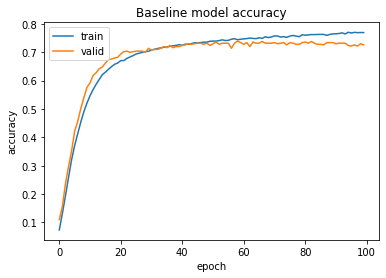

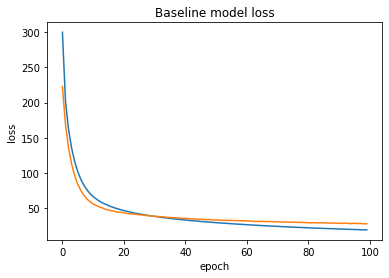

In [ ]:
def display_history(history):
    """Summarize history for accuracy and loss.
    """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Baseline model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Baseline model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

# Please use the above defined function to plot the history!
display_history(history)
# Observe how the training proceeded, discuss with a lecturer!

# Baseline + L2 regularizáció

In [ ]:
from tensorflow.keras.regularizers import l2


# Extra parameters

lambda_ = 0.001 # for L2 regularization


# Model
#######
# Please add L2 regularization to your model!
# Specificly:
# 1. Copy over the full model definition, compilation and fit
# 2. Add L2 regularization with the above defined lambda_ parameter as kernel regularizer for each hidden layer!
# Warning: Softmax layer should not be touched!
input_size = 784

hidden_size_1 = 1024

hidden_size_2 = 512

hidden_size_3 = 256

n_classes = 10



# WE USE FUNCTIONAL API!!!!


# Model
#######
# Define an input as x that has thhe shape of input_size
# Remember the tuples please!
inputs=Input(shape=(input_size,))


# Hidden layers
###############
# Define 3 layers of fully connected neural networks
# Please use the abouve set parameters for the layer sizes
# Set the kernel and bias initializers to random uniform
# Please don't forget to "chain" together the layers by calling them on the prior one's output,...
# Naturally, first one gets the input...
r1_reg= tf.keras.regularizers.L2(lambda_)
r2_reg= tf.keras.regularizers.L2(lambda_)
r3_reg= tf.keras.regularizers.L2(lambda_)


l1=Dense(hidden_size_1,kernel_regularizer=r1_reg)(inputs)
l2=Dense(hidden_size_2,kernel_regularizer=r2_reg)(l1)
l3=Dense(hidden_size_3,kernel_regularizer=r3_reg)(l2)


# Softmax 
#########
# Define a dense output layer with softmax, that takes in the prior layer (logits) as input
predictions = Dense(n_classes, activation='softmax')(l3)


# Full model
############
# Please instantiate the Model object, defining proper inputs and outputs for it!


model = Model(inputs=inputs, outputs=predictions)


lossi = sparse_categorical_crossentropy # we use this cross entropy variant as the input is not 
                                       # one-hot encoded

# Optimizer

optimizer = Adadelta() # A "smart" SGD variant 
 
# Compilation and fitting 
#########################
# Please compile the model, use the above defined optimizer and loss, as well as the "accuracy" metric
# Please bear in mind, that metrics is always a list of strings

model.compile(optimizer=optimizer,
              loss=lossi, # ezt a cross entropy variánst hasnzáljuk
                                                      # mivel az input nem one-hot enkódolt
              metrics=['accuracy'])


# Please observe, that the results of the fitting can be retrieved from the history!
history2 = model.fit(x=train_images, 
                    y=train_labels,
                    validation_data=(valid_images, valid_labels),
                    epochs=100,
                    batch_size=100)



Epoch 1/100
50/50 [==============================] - 2s 34ms/step - loss: 304.6234 - accuracy: 0.0844 - val_loss: 245.1155 - val_accuracy: 0.0980
Epoch 2/100
50/50 [==============================] - 2s 30ms/step - loss: 229.9311 - accuracy: 0.1085 - val_loss: 190.1358 - val_accuracy: 0.1560
Epoch 3/100
50/50 [==============================] - 2s 30ms/step - loss: 178.8637 - accuracy: 0.1583 - val_loss: 148.8770 - val_accuracy: 0.2260
Epoch 4/100
50/50 [==============================] - 2s 31ms/step - loss: 147.5951 - accuracy: 0.2306 - val_loss: 122.6541 - val_accuracy: 0.3260
Epoch 5/100
50/50 [==============================] - 2s 31ms/step - loss: 123.4109 - accuracy: 0.2990 - val_loss: 104.7164 - val_accuracy: 0.3900
Epoch 6/100
50/50 [==============================] - 2s 31ms/step - loss: 108.0188 - accuracy: 0.3577 - val_loss: 92.6233 - val_accuracy: 0.4500
Epoch 7/100
50/50 [==============================] - 2s 30ms/step - loss: 95.7616 - accuracy: 0.4120 - val_loss: 84.2994 - va

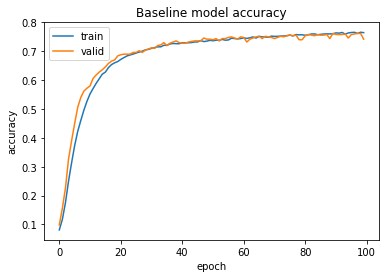

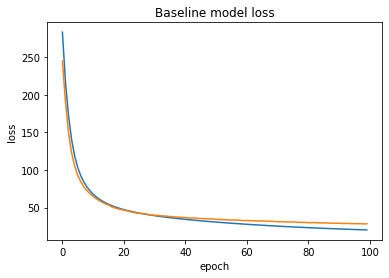

In [ ]:
# Please use the function to visualize the history!

display_history(history2)

# Observe how the training proceeded, discuss with a lecturer!

# Baseline + L1 regularizáció

In [ ]:
from tensorflow.keras.regularizers import l1


# Extra parameters

lambda_ = 0.001 # for L1 regularization

lambda_ = 0.001 # for L2 regularization


# Model
#######
# Please add L2 regularization to your model!
# Specificly:
# 1. Copy over the full model definition, compilation and fit
# 2. Add L2 regularization with the above defined lambda_ parameter as kernel regularizer for each hidden layer!
# Warning: Softmax layer should not be touched!
input_size = 784

hidden_size_1 = 1024

hidden_size_2 = 512

hidden_size_3 = 256

n_classes = 10



# WE USE FUNCTIONAL API!!!!


# Model
#######
# Define an input as x that has thhe shape of input_size
# Remember the tuples please!
inputs=Input(shape=(input_size,))


# Hidden layers
###############
# Define 3 layers of fully connected neural networks
# Please use the abouve set parameters for the layer sizes
# Set the kernel and bias initializers to random uniform
# Please don't forget to "chain" together the layers by calling them on the prior one's output,...
# Naturally, first one gets the input...
r1_reg= tf.keras.regularizers.L1(lambda_)
r2_reg= tf.keras.regularizers.L1(lambda_)
r3_reg= tf.keras.regularizers.L1(lambda_)


l1=Dense(hidden_size_1,kernel_regularizer=r1_reg)(inputs)
l2=Dense(hidden_size_2,kernel_regularizer=r2_reg)(l1)
l3=Dense(hidden_size_3,kernel_regularizer=r3_reg)(l2)


# Softmax 
#########
# Define a dense output layer with softmax, that takes in the prior layer (logits) as input
predictions = Dense(n_classes, activation='softmax')(l3)


# Full model
############
# Please instantiate the Model object, defining proper inputs and outputs for it!


model = Model(inputs=inputs, outputs=predictions)


lossi = sparse_categorical_crossentropy # we use this cross entropy variant as the input is not 
                                       # one-hot encoded

# Optimizer

optimizer = Adadelta() # A "smart" SGD variant 
 
# Compilation and fitting 
#########################
# Please compile the model, use the above defined optimizer and loss, as well as the "accuracy" metric
# Please bear in mind, that metrics is always a list of strings

model.compile(optimizer=optimizer,
              loss=lossi, # ezt a cross entropy variánst hasnzáljuk
                                                      # mivel az input nem one-hot enkódolt
              metrics=['accuracy'])


# Please observe, that the results of the fitting can be retrieved from the history!
history3 = model.fit(x=train_images, 
                    y=train_labels,
                    validation_data=(valid_images, valid_labels),
                    epochs=100,
                    batch_size=100)




Epoch 1/100
50/50 [==============================] - 2s 36ms/step - loss: 483.5469 - accuracy: 0.1039 - val_loss: 331.8232 - val_accuracy: 0.1080
Epoch 2/100
50/50 [==============================] - 2s 32ms/step - loss: 311.0030 - accuracy: 0.1069 - val_loss: 247.9984 - val_accuracy: 0.1420
Epoch 3/100
50/50 [==============================] - 2s 32ms/step - loss: 242.1452 - accuracy: 0.1522 - val_loss: 206.0495 - val_accuracy: 0.1880
Epoch 4/100
50/50 [==============================] - 2s 33ms/step - loss: 203.9670 - accuracy: 0.2049 - val_loss: 176.5114 - val_accuracy: 0.2740
Epoch 5/100
50/50 [==============================] - 2s 32ms/step - loss: 180.3959 - accuracy: 0.2550 - val_loss: 155.1887 - val_accuracy: 0.3240
Epoch 6/100
50/50 [==============================] - 2s 32ms/step - loss: 157.5841 - accuracy: 0.3172 - val_loss: 139.4222 - val_accuracy: 0.3860
Epoch 7/100
50/50 [==============================] - 2s 31ms/step - loss: 144.1076 - accuracy: 0.3644 - val_loss: 128.7854 -

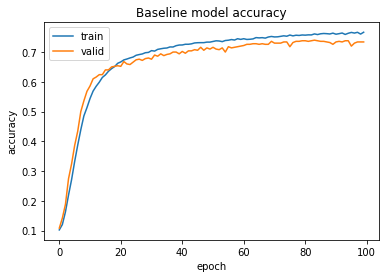

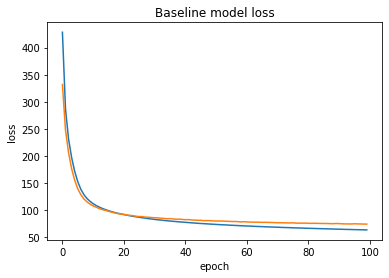

In [ ]:
# Please use the function to visualize the history!

display_history(history3)
# Observe how the training proceeded, discuss with a lecturer!

# Baseline + dropout

In [ ]:
from tensorflow.keras.layers import Dropout


# Parameters

drop_frac = 0.35 # Fraction to drop

# Model
#######
# Please add dropout to your model!
# Specificly:
# 1. Copy over the full model definition, compilation and fit
# 2. Add dropout layers with the above defined drop_frac fraction AFTER EACH HIDDEN LAYER
# (Encapsulation their outputs)
# Warning: Softmax layer MUST be the last one, no dropping after it!


# Extra parameters

lambda_ = 0.001 # for L1 regularization

lambda_ = 0.001 # for L2 regularization


# Model
#######
# Please add L2 regularization to your model!
# Specificly:
# 1. Copy over the full model definition, compilation and fit
# 2. Add L2 regularization with the above defined lambda_ parameter as kernel regularizer for each hidden layer!
# Warning: Softmax layer should not be touched!
input_size = 784

hidden_size_1 = 1024

hidden_size_2 = 512

hidden_size_3 = 256

n_classes = 10



# WE USE FUNCTIONAL API!!!!


# Model
#######
# Define an input as x that has thhe shape of input_size
# Remember the tuples please!
inputs=Input(shape=(input_size,))


# Hidden layers
###############
# Define 3 layers of fully connected neural networks
# Please use the abouve set parameters for the layer sizes
# Set the kernel and bias initializers to random uniform
# Please don't forget to "chain" together the layers by calling them on the prior one's output,...
# Naturally, first one gets the input...
r1_reg= tf.keras.regularizers.L1(lambda_)
r2_reg= tf.keras.regularizers.L1(lambda_)
r3_reg= tf.keras.regularizers.L1(lambda_)


l1=Dense(hidden_size_1,kernel_regularizer=r1_reg)(inputs)
d1=Dropout(drop_frac)(l1)
l2=Dense(hidden_size_2,kernel_regularizer=r2_reg)(d1)
d2=Dropout(drop_frac)(l2)
l3=Dense(hidden_size_3,kernel_regularizer=r3_reg)(d2)
d3=Dropout(drop_frac)(l3)



# Softmax 
#########
# Define a dense output layer with softmax, that takes in the prior layer (logits) as input
predictions = Dense(n_classes, activation='softmax')(d3)


# Full model
############
# Please instantiate the Model object, defining proper inputs and outputs for it!


model = Model(inputs=inputs, outputs=predictions)


lossi = sparse_categorical_crossentropy # we use this cross entropy variant as the input is not 
                                       # one-hot encoded

# Optimizer

optimizer = Adadelta() # A "smart" SGD variant 
 
# Compilation and fitting 
#########################
# Please compile the model, use the above defined optimizer and loss, as well as the "accuracy" metric
# Please bear in mind, that metrics is always a list of strings

model.compile(optimizer=optimizer,
              loss=lossi, # ezt a cross entropy variánst hasnzáljuk
                                                      
              metrics=['accuracy'])


# Please observe, that the results of the fitting can be retrieved from the history!
history4 = model.fit(x=train_images, 
                    y=train_labels,
                    validation_data=(valid_images, valid_labels),
                    epochs=300,
                    batch_size=40)





Epoch 1/300
125/125 [==============================] - 4s 26ms/step - loss: 769.2531 - accuracy: 0.1144 - val_loss: 287.0305 - val_accuracy: 0.1580
Epoch 2/300
125/125 [==============================] - 3s 24ms/step - loss: 691.5446 - accuracy: 0.1284 - val_loss: 233.8099 - val_accuracy: 0.2160
Epoch 3/300
125/125 [==============================] - 3s 25ms/step - loss: 634.0145 - accuracy: 0.1508 - val_loss: 196.5658 - val_accuracy: 0.2620
Epoch 4/300
125/125 [==============================] - 3s 25ms/step - loss: 586.5555 - accuracy: 0.1725 - val_loss: 171.1843 - val_accuracy: 0.3440
Epoch 5/300
125/125 [==============================] - 3s 24ms/step - loss: 557.6385 - accuracy: 0.1852 - val_loss: 155.8366 - val_accuracy: 0.4140
Epoch 6/300
125/125 [==============================] - 3s 25ms/step - loss: 532.3510 - accuracy: 0.2001 - val_loss: 144.4138 - val_accuracy: 0.4780
Epoch 7/300
125/125 [==============================] - 3s 24ms/step - loss: 504.2266 - accuracy: 0.2161 - val_lo

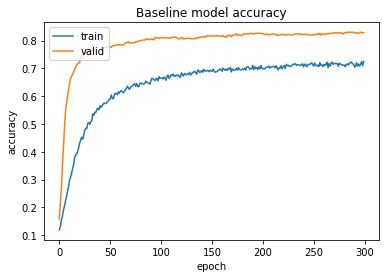

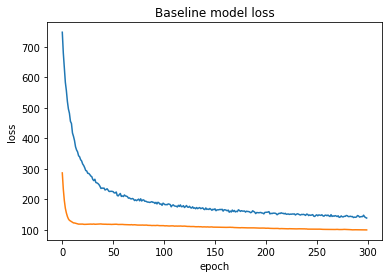

In [ ]:
# Please use the function to visualize the history!

display_history(history4)

# Observe how the training proceeded, discuss with a lecturer!

In [ ]:
history4.

SyntaxError: ignored